In [1]:
import astropy.io.fits as fits
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from astropy.visualization import simple_norm
import ccdproc as ccd
from astropy import visualization as viz
from astropy.visualization import (imshow_norm, MinMaxInterval, SqrtStretch, ZScaleInterval)
from astropy.coordinates import SkyCoord
from photutils.aperture import ApertureStats
from astropy.stats import SigmaClip
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from astropy.wcs import WCS
from astropy.table import Table
from astropy.io import ascii
from astropy import units as u
from datetime import datetime
from astropy.time import Time

In [2]:
# Sunset is 7:09 PM 
# By at observatory at 6:39 PM to take sky flats
# Ideally be done by 10 PM 

In [3]:
data = ascii.read('landoltstars.txt')  

In [4]:
star_pos = SkyCoord('16h41m41.24s', '36:27:35.5', unit=(u.hourangle, u.deg))
star_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (250.42183333, 36.45986111)>

In [5]:
data[0]

<Row index=0>
StarDesignation RA(2000) Dec(2000)    V      B-V     U-B     V-R     R-I     V-I  
     str11        str8      str9   float64 float64 float64 float64 float64 float64
--------------- -------- --------- ------- ------- ------- ------- ------- -------
         TPHE A 00:30:09 -46:31:22  14.651   0.793    0.38   0.435   0.405   0.841

In [6]:
len(data)

526

In [7]:
st = SkyCoord(data[0]['RA(2000)'], data[0]['Dec(2000)'], unit=(u.hourangle, u.deg))
st

<SkyCoord (ICRS): (ra, dec) in deg
    (7.5375, -46.52277778)>

In [8]:
st.separation(star_pos).hour

8.874273021712979

In [9]:
lands = []
for star in data:
    ra = star['RA(2000)']
    dec = star['Dec(2000)']
    coord = SkyCoord(ra, dec, unit=(u.hourangle, u.deg))
    #dist.append(coord.separation(star_pos))
    if star['V'] < 9.5 and coord.separation(star_pos).degree < 60:
        print(star)
        print('Separation:',coord.separation(star_pos).degree)
        lands.append(star)

StarDesignation RA(2000) Dec(2000)   V    B-V   U-B   V-R   R-I   V-I 
--------------- -------- --------- ----- ----- ----- ----- ----- -----
        109 231 17:45:20 -00:26:13 9.332 1.462 1.593 0.785 0.704 1.492
Separation: 39.74439851862938
StarDesignation RA(2000) Dec(2000)   V    B-V   U-B   V-R   R-I   V-I 
--------------- -------- --------- ----- ----- ----- ----- ----- -----
        111 773 19:37:17 +00:10:38 8.963 0.206 -0.21 0.119 0.144 0.262
Separation: 54.45338332240191


In [10]:
lands

[<Row index=388>
 StarDesignation RA(2000) Dec(2000)    V      B-V     U-B     V-R     R-I     V-I  
      str11        str8      str9   float64 float64 float64 float64 float64 float64
 --------------- -------- --------- ------- ------- ------- ------- ------- -------
         109 231 17:45:20 -00:26:13   9.332   1.462   1.593   0.785   0.704   1.492,
 <Row index=431>
 StarDesignation RA(2000) Dec(2000)    V      B-V     U-B     V-R     R-I     V-I  
      str11        str8      str9   float64 float64 float64 float64 float64 float64
 --------------- -------- --------- ------- ------- ------- ------- ------- -------
         111 773 19:37:17 +00:10:38   8.963   0.206   -0.21   0.119   0.144   0.262]

### Landolt Star Photometry

$V_{Landolt} = V_{Observed} + a (X-1) + b (X-1) (V_{Landolt}-I_{Landolt}) + ZP$

In [11]:
# For standard correction
# air mass
# airmass and color
# vega? 

## Data Reduction

In [12]:
directory = '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/*'
glob(directory)

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/bias',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/dark',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/flat_I',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/flat_V',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/Observation Plan (10_6).docx',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/ObservationPlan.pdf',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/vega']

In [13]:
files_bias = glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/bias/*')
files_dark = glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/dark/*')
files_flatI =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/flat_I/*')
files_flatV =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/flat_V/*')
#files_m2 =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/*')
files_m2_I = glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/*')
files_m2_V = glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Vband/*')
files_vega_I =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/vega/*_I_*')
files_vega_V =  glob('/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/vega/*_V_*')

In [14]:
def get_exptime(filename):
    return fits.getheader(filename)['EXPTIME']
def get_filter(filename):
    return fits.getheader(filename)['FILTER']
def get_obstime(filename):
    return Time(fits.getheader(filename)['DATE-OBS'])
def get_localtime(filename):
    return fits.getheader(filename)['NOTE'][11:]

In [15]:
names = ['Target', 'Exposure Time (s)', 'Filters', 'Number of Exposures', 'ObsTime (UTC)', 'Right Ascension', 'Declination']
filetype = ['Bias', 'Dark', 'I-Band Flat', 'V-Band Flat', 'Messier 2 I-Band', 'Messier 2 V-Band', 'Vega I-Band', 'Vega V-Band']
filelist = [files_bias, files_dark, files_flatI, files_flatV, files_m2_I, files_m2_V, files_vega_I, files_vega_V]
exptime = []
filters = []
numfiles = []
obstime = []
localtime = []
coord_m2 = SkyCoord('21h33m27s', '-00d49m23.7s', frame='fk5')
coord_vega = SkyCoord('18h36m56s', '+38d47m1s', frame='fk5')

coords_ra  = ['-', '-', '-', '-', '21h33m27s', '21h33m27s', '18h36m56s', '18h36m56s']
coords_dec = ['-', '-', '-', '-', '-00$^{\circ}$49\'23.7\"', '-00$^{\circ}$49\'23.7\"', '+38$^{\circ}$47\'1\"', '+38$^{\circ}$47\'1\"']

for lis in filelist:
    exptime.append(get_exptime(lis[0]))
    filters.append(get_filter(lis[0]))
    numfiles.append(len(lis))
    obstime.append(get_obstime(lis[0]))
    localtime.append(get_localtime(lis[0]))

In [16]:
Time(fits.getheader(files_m2_V[0])['DATE-OBS'])

<Time object: scale='utc' format='isot' value=2022-10-07T01:51:05.000>

In [17]:
fits.getheader(files_bias[0])['NOTE'][11:]

'10/6/2022 at 18:57:46.000'

In [18]:
tblr = Table([filetype, exptime, filters, numfiles, obstime, coords_ra, coords_dec], names=names)
tblr.write('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive/obstable.dat', format='latex', overwrite=True)

In [19]:
pwd

'/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive'

In [20]:
fits.getheader(files_bias[0])

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                  765 /                                                
NAXIS2  =                  510 /                                                
OBJECT  = '        '           /                                                
TELESCOP= 'Celestron CPC 12'''                                                  
INSTRUME= 'SBIG ST-402'                                                         
OBSERVER= 'Daniel_Emma_Alex'                                                    
DATE-OBS= '2022-10-06T22:57:46.000' / GMT START OF EXPOSURE [WIN]               
BZERO   = +3.276800000000E+004 /                                                
BSCALE  = +1.000000000000E+000 /                                                
EXPTIME = +4.000000000000E-0

In [21]:
ccd_shape = fits.getdata(files_bias[0]).shape

### Bias

In [22]:
bias = np.zeros((len(files_bias), ccd_shape[0], ccd_shape[1]))
for bb in range(len(files_bias)):
    #print(files_bias[bb])
    bias[bb] = fits.getdata(files_bias[bb])

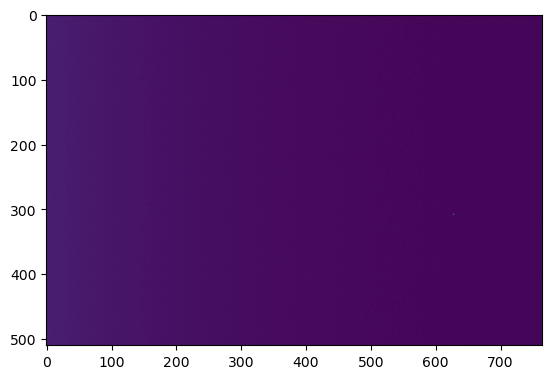

In [23]:
master_bias = np.median(bias, axis=0)
plt.imshow(master_bias)

In [24]:
master_bias.mean()

1088.0907497116493

### Darks

In [25]:
exptime_darkI = fits.getheader(files_m2_V[0])['EXPTIME']
exptime_darkI

20.0

In [26]:
exptime_darkV = fits.getheader(files_dark[0])['EXPTIME']
exptime_darkV

20.0

In [27]:
dark = np.zeros((len(files_dark), ccd_shape[0], ccd_shape[1]))
for bb in range(len(files_dark)):
    #print(files_bias[bb])
    dark[bb] = fits.getdata(files_dark[bb])

9.130502370882994

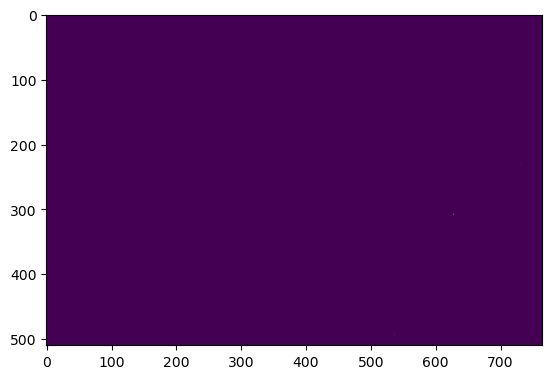

In [28]:
master_dark = np.median(dark-master_bias, axis=0)
plt.imshow(master_dark)
np.mean(master_dark)

### Flats

In [29]:
exptime_flatI = fits.getheader(files_flatI[0])['EXPTIME']

In [30]:
flatI = np.zeros((len(files_flatI), ccd_shape[0], ccd_shape[1]))
for bb in range(len(files_flatI)):
    #print(files_bias[bb])
    flatI[bb] = fits.getdata(files_flatI[bb]) - master_bias - exptime_flatI/exptime_darkI * master_dark

30056.210125195445

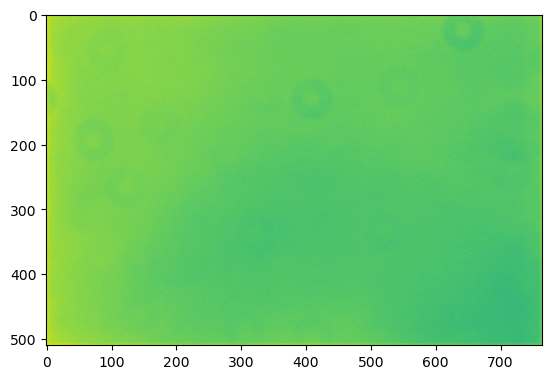

In [31]:
master_flatI = np.median(flatI, axis=0)
plt.imshow(master_flatI)
np.mean(master_flatI)

0.9999999999999997

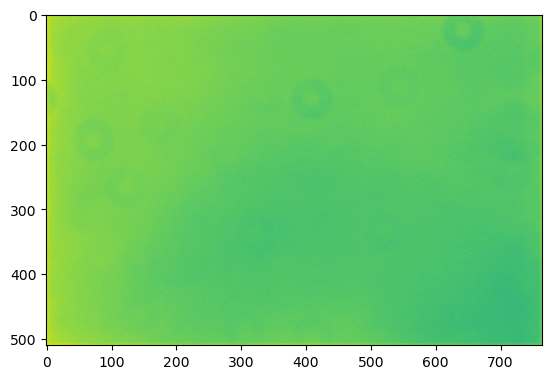

In [32]:
master_flatI_norm = master_flatI/np.mean(master_flatI)
plt.imshow(master_flatI_norm)
np.mean(master_flatI_norm)

In [33]:
exptime_flatV = fits.getheader(files_flatV[0])['EXPTIME']

In [34]:
flatV = np.zeros((len(files_flatV), ccd_shape[0], ccd_shape[1]))
for bb in range(len(files_flatV)):
    #print(files_bias[bb])
    flatV[bb] = fits.getdata(files_flatV[bb]) - master_bias - exptime_flatV/exptime_darkV * master_dark

25671.547239965388

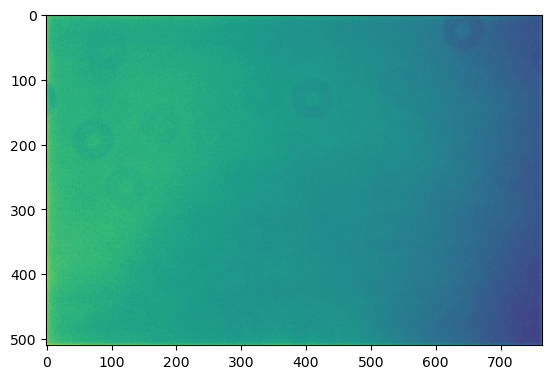

In [35]:
master_flatV = np.median(flatV, axis=0)-master_bias
plt.imshow(master_flatV)
np.mean(master_flatV)

1.0000000000000002

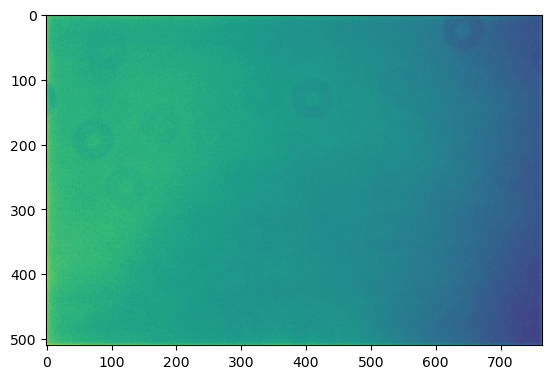

In [36]:
master_flatV_norm = master_flatV/np.mean(master_flatV)
plt.imshow(master_flatV_norm)
np.mean(master_flatV_norm)

A Note about the flats:

These flats were taken as sky flats before astronomical twilight. As part of the process of aiming the telescope at the North star to center it, the CCD was removed from the back of the telescope. Afterwards, it was placed back on, but imperfectly so that the dust on the optics was not in the same place. In the calibrated science images to follow, the "donuts" from dust particles on the optics are visible because of this.

### Calibration

$[(flat-bias)-\frac{t_f}{t_d}(dark-bias)]_{ave}[\frac{(object-bias)-\frac{t_o}{t_d}(dark-bias)}{(flat-bias)-\frac{t_f}{t_d}(dark-bias)}]_{pix}$

$[master\_flat-\frac{exptime\_flat}{exptime\_dark}(master\_dark)]_{ave}[\frac{(object-master\_bias)
-\frac{exptime\_obj}{exptime\_dark}(master\_dark)}{(master\_flat)-\frac{exptime\_flat}{exptime\_dark}(master\_dark)}]_{pix}$

#### M2

In [37]:
files_m2_I

['/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_001.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_002.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_003.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_004.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_001.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_002.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_003.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_004.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_005.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband/m2_I20s_r2_006.FIT',
 '/mnt/c/Users/panda/Documents/ObsAstronomy/ObsData/LabFiveData/m2/Iband

In [38]:
data_m2_I = np.zeros((len(files_m2_I), ccd_shape[0], ccd_shape[1]))

for ff in range(len(files_m2_I)):
    data_m2_I[ff] = (fits.getdata(files_m2_I[ff])-master_dark) / master_flatI_norm

In [39]:
pwd

'/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive'

Very blurry because the telescope does not track well. Need to have something that accounts for the movement of the stars in every science frame.


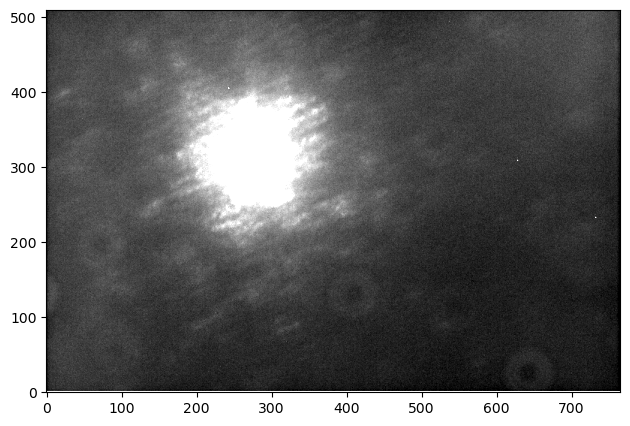

In [40]:
norm_ex = np.median(data_m2_I, axis=0)
imshow_norm(norm_ex, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
print('Very blurry because the telescope does not track well. Need to have something that accounts for the movement of the stars in every science frame.')
plt.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive/plots/blurry.pdf')

(<matplotlib.image.AxesImage at 0x7f2df564f370>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f2df56e06d0>)

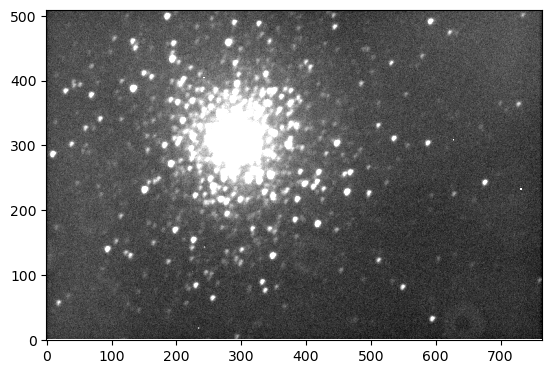

In [41]:
im1 = data_m2_I[0]
imshow_norm(im1, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [42]:
bkg_sigma = mad_std(im1)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(im1)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
#print(sources)

In [43]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  

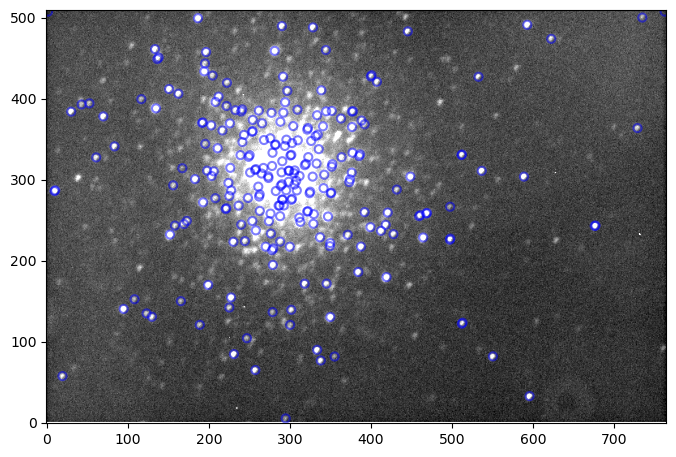

In [44]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(im1, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
#annulus_aperture.plot(color='blue', lw=1.5, alpha=0.1)
print('')

In [45]:
star = (677, 243)#(597, 34)

In [46]:
#dist = np.sqrt((positions[:,0]-star[0])**2 + (positions[:,1]-star[1])**2)
#index = np.where(np.min(dist) == dist)
#pos = positions[index][0]
#star_pos.append(pos)
#ids.append(index)

In [47]:
#pos

In [48]:
from astropy.visualization import ImageNormalize

##### Image Combination

In [49]:
#imshow_norm(im1, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
#shifted = []
data_m2_I = np.zeros((len(files_m2_I), ccd_shape[0], ccd_shape[1]))

for ff in range(len(files_m2_I)):
    im = (fits.getdata(files_m2_I[ff])-master_dark) / master_flatI_norm
    bkg_sigma = mad_std(im)  
    daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
    sources = daofind(im)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures = CircularAperture(positions, r=5.) 
    dist = np.sqrt((positions[:,0]-star[0])**2 + (positions[:,1]-star[1])**2)
    index = np.where(np.min(dist) == dist)
    pos = positions[index][0]
    aper = CircularAperture(positions, r=5.) 
    #aper[index].plot(color='blue', lw=1.5, alpha=0.5)
    
    shi = np.roll(im, (int(star[1]-pos[1]), int(star[0]-pos[0])), axis=(0,1))
    
    #fig, axs = plt.subplots(1, 2, figsize=(9,9))
    #axs[0].imshow(im, norm=ImageNormalize(data=im, interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
    #axs[0].scatter(pos[0], pos[1], marker='.', color='blue', alpha=0.5)
    #axs[0].scatter(star[0], star[1], marker='.', color='red', alpha=0.5)
    #axs[1].imshow(shi, norm=ImageNormalize(data=shi, interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
    #axs[1].scatter(pos[0], pos[1], marker='.', color='blue', alpha=0.5)
    #axs[1].scatter(star[0], star[1], marker='.', color='red', alpha=0.5)
    
    data_m2_I[ff] = shi
    #print(im)
    
    #np.roll(im, pos-star)

In [50]:
#star_V = (594, 290)
star_V = (555, 70)
#star_V = (355, 177)
#star_V = (600, 21)
#star_V = (599, 479)
#star_V = (682, 230)

In [51]:
#imshow_norm(fits.getdata(files_m2_V[0]), origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
#shifted = []
data_m2_V = np.zeros((len(files_m2_V), ccd_shape[0], ccd_shape[1]))

for ff in range(len(files_m2_V)):
    im = (fits.getdata(files_m2_V[ff])-master_dark) / master_flatV_norm
    bkg_sigma = mad_std(im)  
    daofind = DAOStarFinder(fwhm=4., threshold=2.5 * bkg_sigma)  
    sources = daofind(im)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
    apertures = CircularAperture(positions, r=5.) 
    dist = np.sqrt((positions[:,0]-star_V[0])**2 + (positions[:,1]-star_V[1])**2)
    index = np.where(np.min(dist) == dist)
    pos = positions[index][0]
    aper = CircularAperture(positions, r=5.) 
    #aper[index].plot(color='blue', lw=1.5, alpha=0.5)
    
    print(np.sqrt((pos[0]-star_V[0])**2 + (pos[1]-star_V[1])**2))
    shi = np.roll(im, (int(star_V[1]-pos[1]), int(star_V[0]-pos[0])), axis=(0,1))
    
    #fig, axs = plt.subplots(1, 2, figsize=(9,9))
    #axs[0].imshow(im, norm=ImageNormalize(data=im, interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
    #axs[0].scatter(pos[0], pos[1], marker='.', color='blue', alpha=0.5)
    #axs[0].scatter(star_V[0], star_V[1], marker='.', color='red', alpha=0.5)
    #axs[1].imshow(shi, norm=ImageNormalize(data=shi, interval=ZScaleInterval(), stretch=viz.LinearStretch()), origin='lower', cmap='gray')
    #axs[1].scatter(pos[0], pos[1], marker='.', color='blue', alpha=0.5)
    #axs[1].scatter(star_V[0], star_V[1], marker='.', color='red', alpha=0.5)
    
    if np.sqrt((pos[0]-star_V[0])**2 + (pos[1]-star_V[1])**2) > 30.:
        print('Selected star too far away')
    else: 
        data_m2_V[ff] = shi
    #print(im)
    
    #np.roll(im, pos-star)

26.53738398585733
21.83304490504877
21.953036079431303
46.23193614817681
Selected star too far away
12.23206935111877
10.70735201945291
9.572564077172094
9.091323261693075
8.902041990812997
43.06073330763313
Selected star too far away
1.3256166289841604
5.831531623950198
11.455285389002357
5.18858963701437
5.318678335272187
5.538186868950662
14.841000883137074
14.090627098947493
11.151455903061647
9.690312857984582


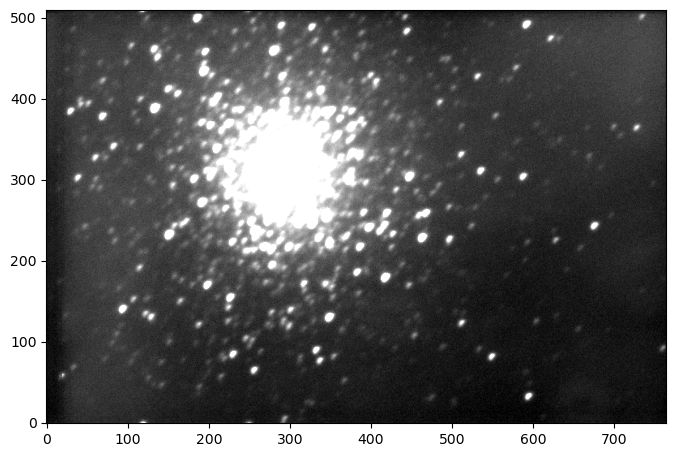

In [52]:
image_combined_I = np.median(data_m2_I, axis=0)
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_I, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

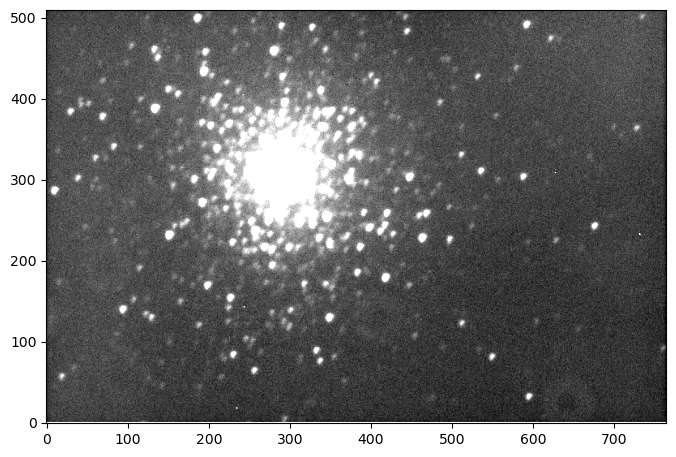

In [53]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(data_m2_I[0], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

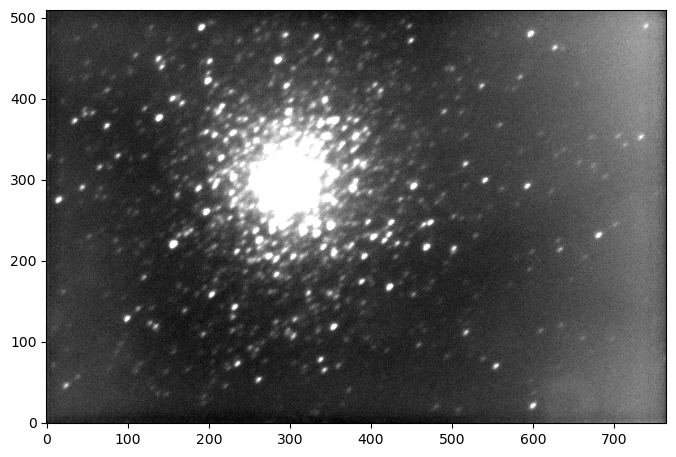

In [54]:
image_combined_V = np.median(data_m2_V, axis=0)
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_V, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

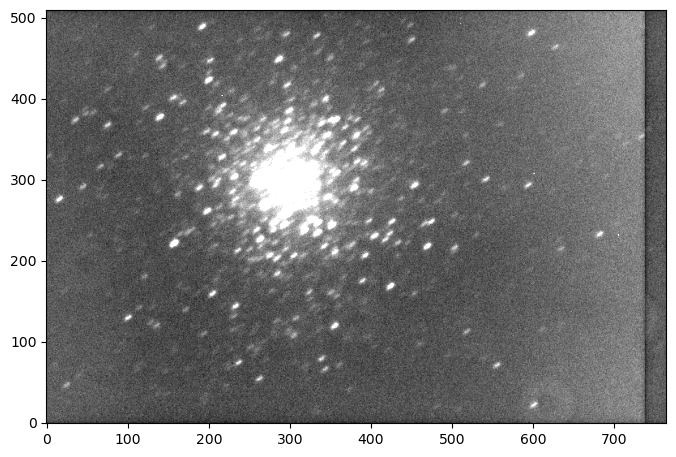

In [55]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(data_m2_V[0], origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

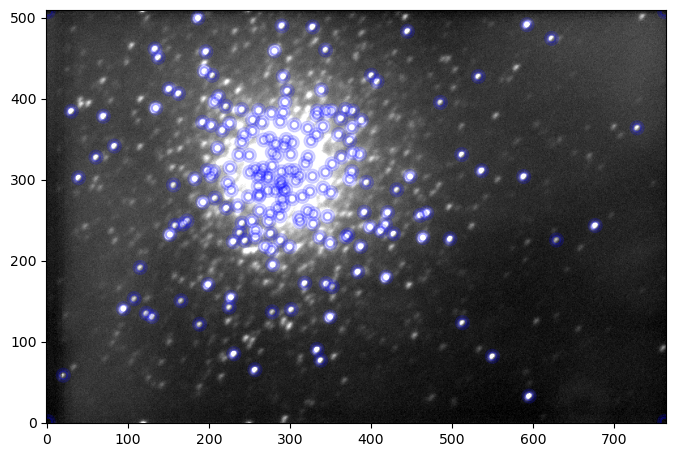

In [56]:
bkg_sigma = mad_std(image_combined_I)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(image_combined_I)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  
annuli = CircularAnnulus(positions, 5., 8.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_I, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.2)
annuli.plot(color='blue', lw=1.5, alpha=0.2)

print('')

In [57]:
aperstats = ApertureStats(image_combined_I, annuli)
bkg_mean = aperstats.mean
phot_table_I = aperture_photometry(image_combined_I, apertures)
aperture_area = apertures.area_overlap(image_combined_I)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_I['aperture_sum'] - total_bkg
phot_table_I['total_bkg'] = total_bkg
phot_table_I['aperture_sum_bkgsub'] = phot_bkgsub

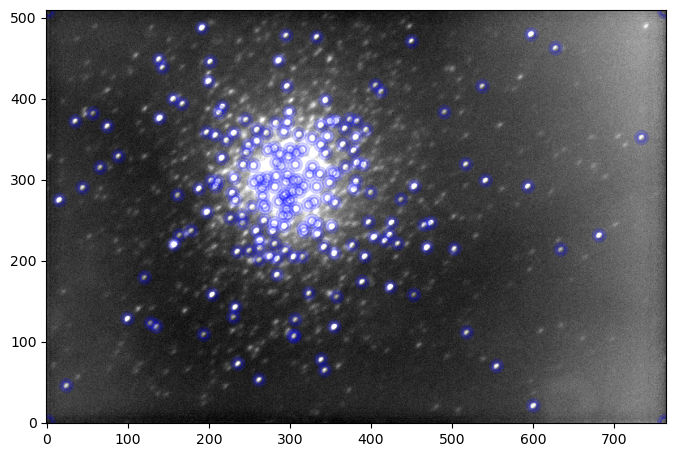

In [58]:
bkg_sigma = mad_std(image_combined_V)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(image_combined_V)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  
annuli = CircularAnnulus(positions, 5., 8.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_V, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.2)
annuli.plot(color='blue', lw=1.5, alpha=0.2)

print('')

In [59]:
aperstats = ApertureStats(image_combined_V, annuli)
bkg_mean = aperstats.mean
phot_table_V = aperture_photometry(image_combined_V, apertures)
aperture_area = apertures.area_overlap(image_combined_V)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_V['aperture_sum'] - total_bkg
phot_table_V['total_bkg'] = total_bkg
phot_table_V['aperture_sum_bkgsub'] = phot_bkgsub

In [60]:
#color = phot_table_V['aperture_sum_bkgsub'] - phot_table_I['aperture_sum_bkgsub']
#magnitude = phot_table_V['aperture_sum_bkgsub']

In [61]:
x_VIshift = phot_table_V[4]['xcenter'] - phot_table_I[4]['xcenter']
y_VIshift = phot_table_V[4]['ycenter'] - phot_table_I[4]['ycenter']

In [62]:
x_VIshift

<Quantity 5.18889173 pix>

In [63]:
y_VIshift

<Quantity -12.35472029 pix>

In [64]:
int(star_V[1]-pos[1])

-8

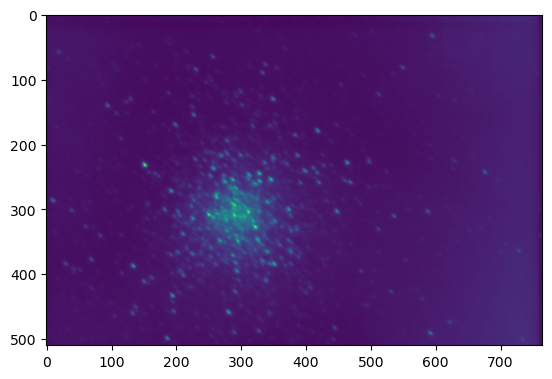

In [65]:
r = np.roll(image_combined_V, (-int(x_VIshift.value), -int(y_VIshift.value)), axis=(1,0))
plt.imshow(r)

##### Photometry

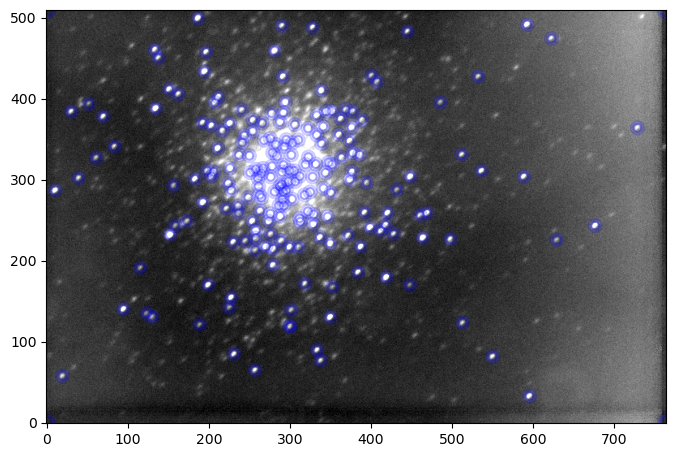

In [66]:
bkg_sigma = mad_std(r)  
daofind = DAOStarFinder(fwhm=4., threshold=3. * bkg_sigma)  
sources = daofind(r)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  
annuli = CircularAnnulus(positions, 5., 8.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(r, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.2)
annuli.plot(color='blue', lw=1.5, alpha=0.2)

print('')

In [67]:
aperstats = ApertureStats(image_combined_V, annuli)
bkg_mean = aperstats.mean
phot_table_V = aperture_photometry(image_combined_V, apertures)
aperture_area = apertures.area_overlap(image_combined_V)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_V['aperture_sum'] - total_bkg
phot_table_V['total_bkg'] = total_bkg
phot_table_V['aperture_sum_bkgsub'] = phot_bkgsub

In [68]:
nearest_star = np.zeros(len(phot_table_V))
for st in range(len(phot_table_V)):
    xV = phot_table_V[st]['xcenter']
    yV = phot_table_V[st]['ycenter']
    nearest = 999
    
    for ar in range(len(phot_table_I)):
        xI = phot_table_I[ar]['xcenter']
        yI = phot_table_I[ar]['ycenter']
        dist = np.sqrt((xV-xI)**2+(yV-yI)**2).value
        
        if dist < nearest:
            nearest_star[st] = int(ar)
            nearest = dist

In [69]:
nearest_star

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,  15.,   9.,
        15.,  10.,  11.,  12.,  13.,  15.,  16.,  17.,  20.,  21.,  22.,
        25.,  24.,  25.,  26.,  27.,  28.,  30.,  29.,  31.,  32.,  30.,
        31.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  42.,  41.,  44.,
        43.,  45.,  46.,  49.,  48.,  50.,  51.,  52.,  54.,  55.,  59.,
        57.,  60.,  58.,  61.,  62.,  63.,  64.,  65.,  66.,  74.,  69.,
        67.,  68.,  71.,  70.,  72.,  74.,  73.,  75.,  76.,  82.,  78.,
        77.,  81.,  80.,  83.,  84.,  85.,  86.,  87., 105.,  89.,  90.,
        91.,  92.,  94.,  93.,  95.,  96.,  97.,  96.,  99.,  98., 103.,
       102., 104., 105., 109., 106., 111., 107., 108., 110., 112., 114.,
       113., 116., 115., 118., 120., 117., 121., 119., 122., 123., 124.,
       125., 115., 126., 126., 127., 127., 128., 129., 130., 131., 133.,
       132., 136., 134., 135., 138., 137., 139., 141., 140., 142., 151.,
       143., 144., 146., 147., 148., 144., 149., 15

In [70]:
#color = phot_table_V['aperture_sum_bkgsub'] - phot_table_I['aperture_sum_bkgsub']
#magnitude = phot_table_V['aperture_sum_bkgsub']

In [71]:
nearest_star.size

204

In [72]:
mag = []
color = []
for ss in range(nearest_star.size):
    xs = phot_table_V[ss]['xcenter'] - phot_table_I[int(nearest_star[ss])]['xcenter']
    ys = phot_table_V[ss]['ycenter'] - phot_table_I[int(nearest_star[ss])]['ycenter']
    dist = np.sqrt(xs**2 + ys**2).value
    #print(dist)
    if dist < 1.0:
        mag.append(phot_table_V[ss]['aperture_sum_bkgsub'])
        color.append(phot_table_V[ss]['aperture_sum_bkgsub'] - phot_table_I[int(nearest_star[ss])]['aperture_sum_bkgsub'])

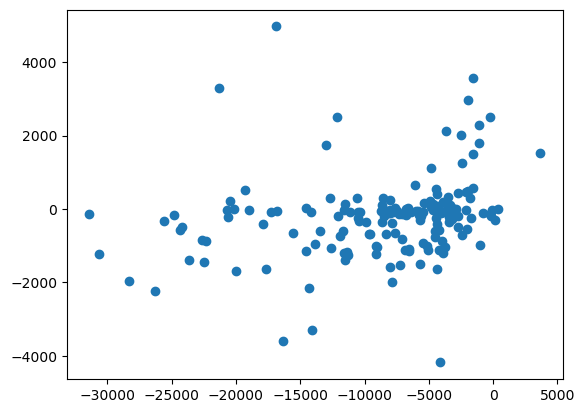

In [73]:
plt.scatter(color, mag)

In [74]:
image_combined_I.shape

(510, 765)

(<matplotlib.patches.Circle at 0x7f2df406aa30>,)

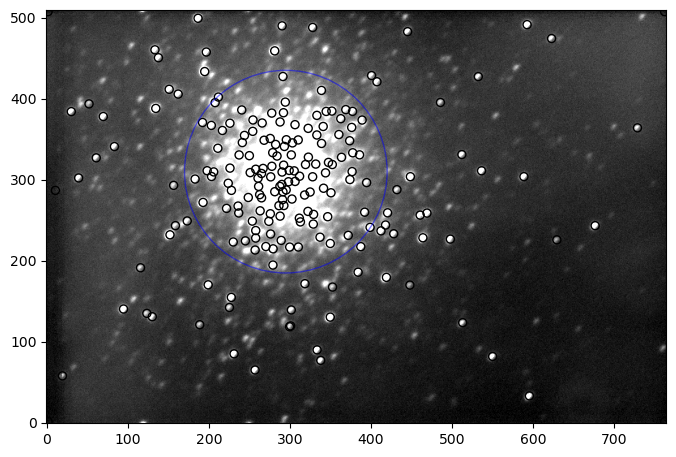

In [75]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_I, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot()
CircularAperture((295, 310), r=125.).plot(color='blue', alpha=0.5)

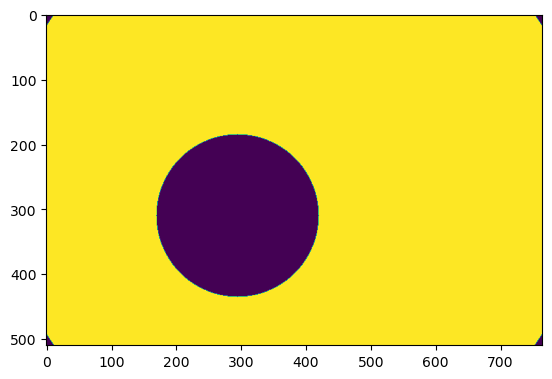

In [76]:
mask = np.ones(image_combined_I.shape)
mask_bool = np.ones(image_combined_I.shape)
center = (295, 310)
radius = 125.
for x in range(mask.shape[1]):
    for y in range(mask.shape[0]):
        dist = np.sqrt((center[0] - x)**2+(center[1] - y)**2)
        if dist <= radius:
            mask[y,x] = 0#np.nan
            mask_bool[y,x] = np.nan
        dist2 = np.sqrt((mask.shape[1]/2 - x)**2+(mask.shape[0]/2 - y)**2)
        if dist2 >= 450:
            mask[y,x] = 0#np.nan
            mask_bool[y,x] = np.nan
        #print(dist)

plt.imshow(mask)


(<matplotlib.patches.Circle at 0x7f2dde8e3310>,)

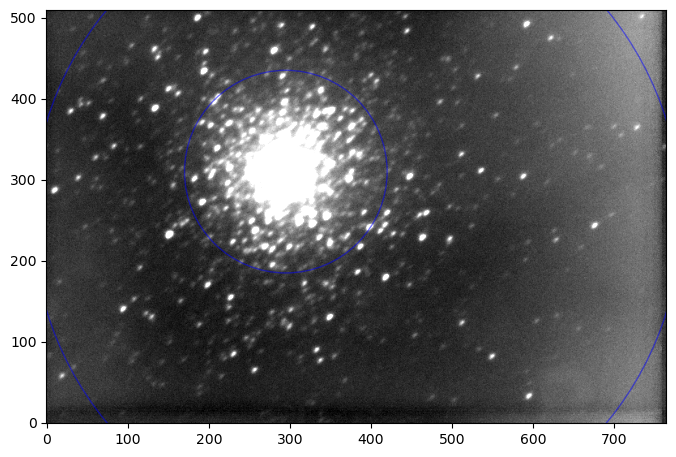

In [77]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(r, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
CircularAperture((295, 310), r=125.).plot(color='blue', alpha=0.5)
CircularAperture((mask.shape[1]/2, mask.shape[0]/2), r=400.).plot(color='blue', alpha=0.5)

In [78]:
im_final_V = r*mask
im_final_I = image_combined_I*mask
im_final_I

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

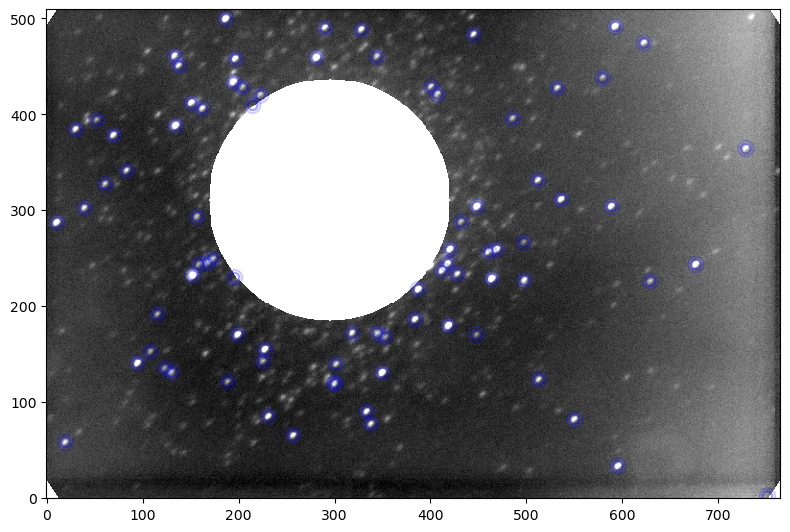

In [79]:
bkg_sigma = mad_std(im_final_V)  
daofind = DAOStarFinder(fwhm=4., threshold=3.0 * bkg_sigma)  
sources = daofind(im_final_V)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  
annuli = CircularAnnulus(positions, 5., 8.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(im_final_V*mask_bool, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.2)
annuli.plot(color='blue', lw=1.5, alpha=0.2)

aperstats = ApertureStats(im_final_V, annuli)
bkg_mean = aperstats.mean
phot_table_V = aperture_photometry(im_final_V, apertures)
aperture_area = apertures.area_overlap(im_final_V)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_V['aperture_sum'] - total_bkg
phot_table_V['total_bkg'] = total_bkg
phot_table_V['aperture_sum_bkgsub'] = phot_bkgsub

print('')
plt.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive/plots/photometry.pdf', bbox_inches='tight')

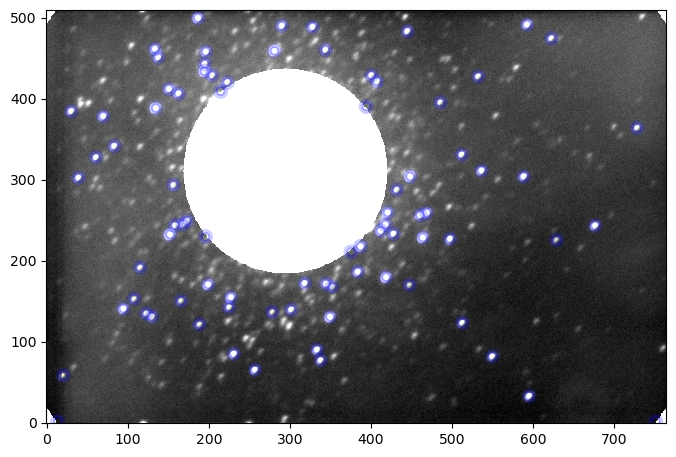

In [80]:
bkg_sigma = mad_std(im_final_I)  
daofind = DAOStarFinder(fwhm=4., threshold=3.0 * bkg_sigma)  
sources = daofind(im_final_I)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=5.)  
annuli = CircularAnnulus(positions, 5., 8.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(im_final_I*mask_bool, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
apertures.plot(color='blue', lw=1.5, alpha=0.2)
annuli.plot(color='blue', lw=1.5, alpha=0.2)

aperstats = ApertureStats(im_final_I, annuli)
bkg_mean = aperstats.mean
phot_table_I = aperture_photometry(im_final_I, apertures)
aperture_area = apertures.area_overlap(im_final_I)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_I['aperture_sum'] - total_bkg
phot_table_I['total_bkg'] = total_bkg
phot_table_I['aperture_sum_bkgsub'] = phot_bkgsub

print('')

In [81]:
nearest_star = np.zeros(len(phot_table_V))
for st in range(len(phot_table_V)):
    xV = phot_table_V[st]['xcenter']
    yV = phot_table_V[st]['ycenter']
    nearest = 999
    
    for ar in range(len(phot_table_I)):
        xI = phot_table_I[ar]['xcenter']
        yI = phot_table_I[ar]['ycenter']
        dist = np.sqrt((xV-xI)**2+(yV-yI)**2).value
        
        if dist < nearest:
            nearest_star[st] = int(ar)
            nearest = dist

In [82]:
mag = []
color = []
for ss in range(nearest_star.size):
    xs = phot_table_V[ss]['xcenter'] - phot_table_I[int(nearest_star[ss])]['xcenter']
    ys = phot_table_V[ss]['ycenter'] - phot_table_I[int(nearest_star[ss])]['ycenter']
    dist = np.sqrt(xs**2 + ys**2).value
    #print(dist)
    if dist < 1.0:
        mag.append(phot_table_V[ss]['aperture_sum_bkgsub'])
        color.append(phot_table_V[ss]['aperture_sum_bkgsub'] - phot_table_I[int(nearest_star[ss])]['aperture_sum_bkgsub'])

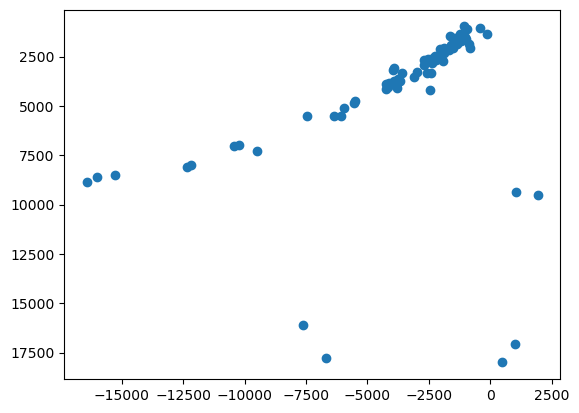

In [83]:
plt.scatter(color, mag)
plt.gca().invert_yaxis()


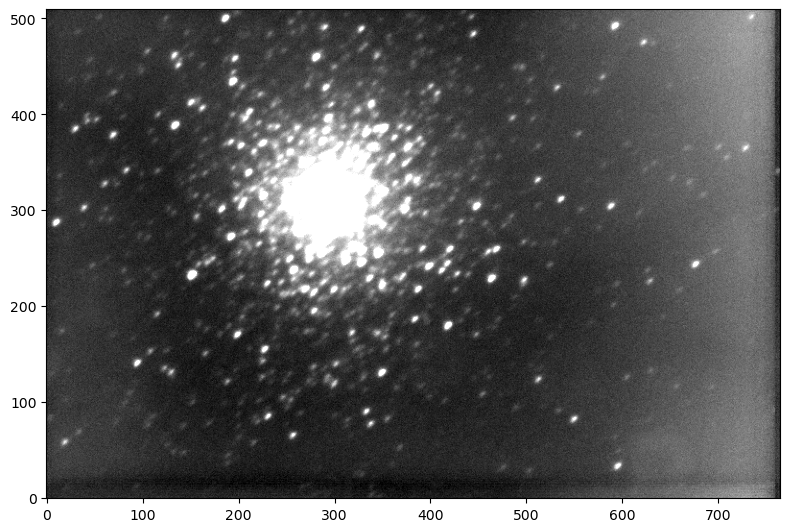

In [84]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(r, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
# Final V-band
plt.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive/plots/messier2V.pdf', bbox_inches='tight')

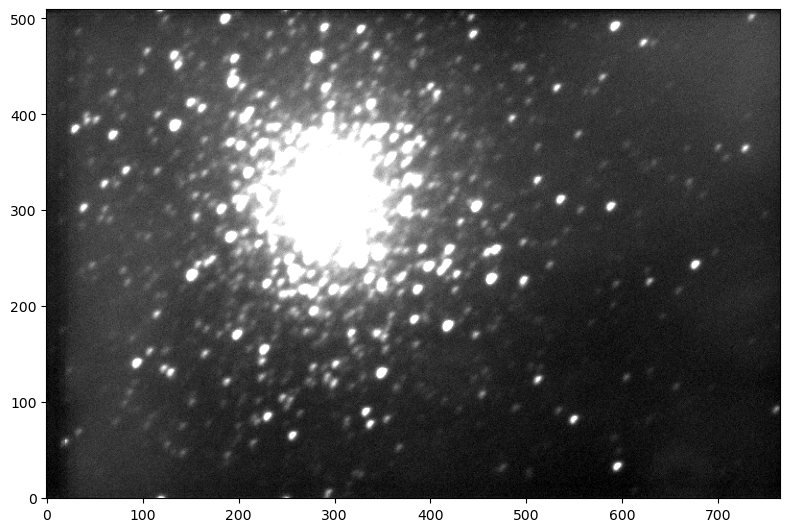

In [85]:
fig = plt.figure(figsize=(8,9))
ax = imshow_norm(image_combined_I, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')
# Fianl I-Band
plt.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive/plots/messier2I.pdf', bbox_inches='tight')

#### Vega

$[master\_flat-\frac{exptime\_flat}{exptime\_dark}(master\_dark)]_{ave}[\frac{(object-master\_bias)
-\frac{exptime\_obj}{exptime\_dark}(master\_dark)}{(master\_flat)-\frac{exptime\_flat}{exptime\_dark}(master\_dark)}]_{pix}$

##### Image Combination

In [86]:
exptime_vegaI = fits.getheader(files_vega_I[0])['EXPTIME']

In [87]:
exptime_darkI

20.0

In [88]:
data_vega_I = np.zeros((len(files_vega_I), ccd_shape[0], ccd_shape[1]))

for ff in range(len(files_vega_I)):
    data_vega_I[ff] = (fits.getdata(files_vega_I[ff])-(exptime_vegaI/exptime_darkI)*master_dark) / master_flatI_norm

(<matplotlib.image.AxesImage at 0x7f2df43e4940>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f2ddeac5eb0>)

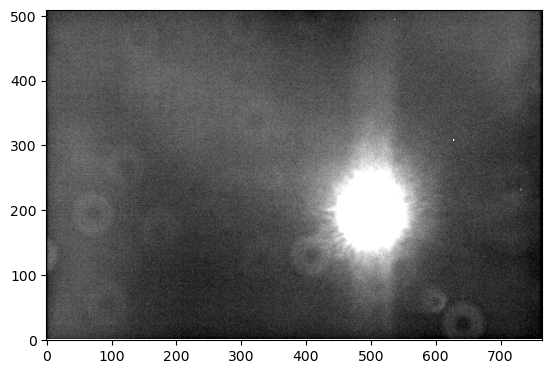

In [89]:
vega_final_I = np.median(data_vega_I, axis=0)
imshow_norm(vega_final_I, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

In [90]:
exptime_vegaV = fits.getheader(files_vega_V[0])['EXPTIME']

In [91]:
data_vega_V = np.zeros((len(files_vega_V), ccd_shape[0], ccd_shape[1]))

for ff in range(len(files_vega_V)):
    data_vega_V[ff] = (fits.getdata(files_vega_V[ff])-(exptime_vegaV/exptime_darkV)*master_dark) / master_flatV_norm

(<matplotlib.image.AxesImage at 0x7f2df42a4d00>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f2df4396fd0>)

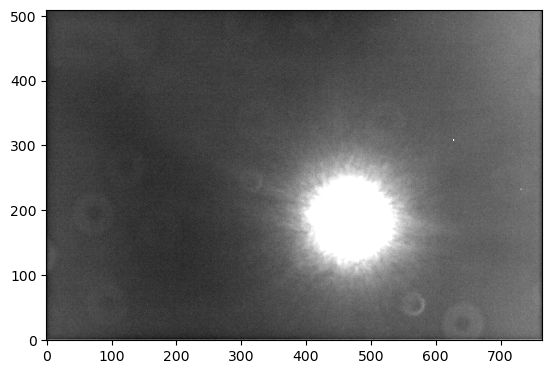

In [92]:
vega_final_V = np.median(data_vega_V, axis=0)
imshow_norm(vega_final_V, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

Note: Vega is definitely over exposed

##### Photometry

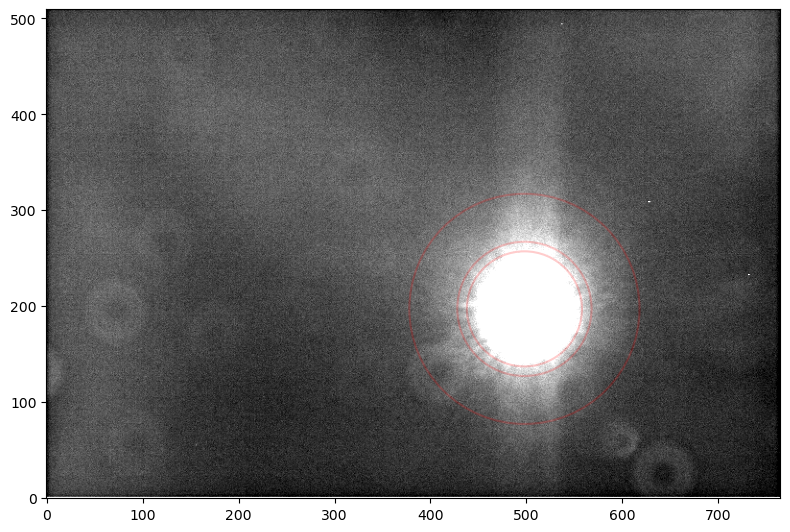

In [93]:
bkg_sigma = mad_std(vega_final_I)  
daofind = DAOStarFinder(fwhm=15., threshold=100.0 * bkg_sigma)  
sources = daofind(vega_final_I)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=60.)  
annuli = CircularAnnulus(positions, 5., 8.)

ap_I = CircularAperture((498, 197), r=60.)
an_I = CircularAnnulus((498, 197), 70., 120.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(vega_final_I, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

ap_I.plot(color='red', lw=1.5, alpha=0.2)
an_I.plot(color='red', lw=1.5, alpha=0.2)

#apertures.plot(color='blue', lw=1.5, alpha=0.2)
#annuli.plot(color='blue', lw=1.5, alpha=0.2)

print('')
plt.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive/plots/vegaI.pdf', bbox_inches='tight')

In [94]:
aperstats = ApertureStats(vega_final_I, an_I)
bkg_mean = aperstats.mean
phot_table_vegaI = aperture_photometry(vega_final_I, ap_I)
aperture_area = ap_I.area_overlap(vega_final_I)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_vegaI['aperture_sum'] - total_bkg
phot_table_vegaI['total_bkg'] = total_bkg
phot_table_vegaI['aperture_sum_bkgsub'] = phot_bkgsub

phot_table_vegaI

<QTable length=1>
  id  xcenter ycenter    aperture_sum       total_bkg      aperture_sum_bkgsub
        pix     pix                                                           
int64 float64 float64      float64           float64             float64      
----- ------- ------- ----------------- ------------------ -------------------
    1   498.0   197.0 59047290.53425324 12600461.476327658   46446829.05792558

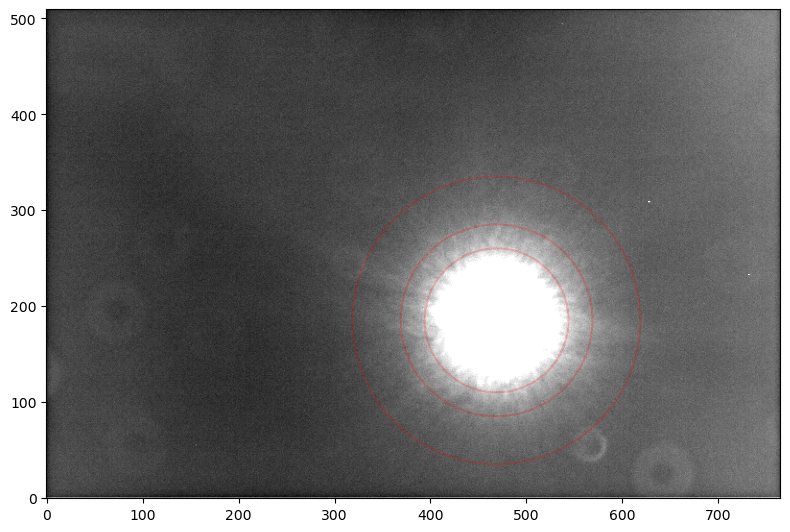

In [95]:
bkg_sigma = mad_std(vega_final_V)  
daofind = DAOStarFinder(fwhm=16., threshold=100.0 * bkg_sigma)  
sources = daofind(vega_final_V)
for col in sources.colnames:  
    sources[col].info.format = '%.8g'  # for consistent table output
    
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=80.)  
annuli = CircularAnnulus(positions, 5., 8.)

ap_V = CircularAperture((469, 185), r=75.)
an_V = CircularAnnulus((469, 185), 100., 150.)

fig = plt.figure(figsize=(8,9))
ax = imshow_norm(vega_final_V, origin='lower', interval=ZScaleInterval(), stretch=viz.LinearStretch(), cmap='gray')

ap_V.plot(color='red', lw=1.5, alpha=0.2)
an_V.plot(color='red', lw=1.5, alpha=0.2)

#apertures.plot(color='blue', lw=1.5, alpha=0.2)
#annuli.plot(color='blue', lw=1.5, alpha=0.2)

print('')
plt.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive/plots/vegaV.pdf', bbox_inches='tight')

In [96]:
aperstats = ApertureStats(vega_final_V, an_V)
bkg_mean = aperstats.mean
phot_table_vegaV = aperture_photometry(vega_final_V, ap_V)
aperture_area = ap_V.area_overlap(vega_final_V)
total_bkg = bkg_mean * aperture_area
phot_bkgsub = phot_table_vegaV['aperture_sum'] - total_bkg
phot_table_vegaV['total_bkg'] = total_bkg
phot_table_vegaV['aperture_sum_bkgsub'] = phot_bkgsub

phot_table_vegaV

<QTable length=1>
  id  xcenter ycenter    aperture_sum        total_bkg      aperture_sum_bkgsub
        pix     pix                                                            
int64 float64 float64      float64            float64             float64      
----- ------- ------- ------------------ ------------------ -------------------
    1   469.0   185.0 115364750.24822222 19942595.759662658   95422154.48855956

In [97]:
phot_table_I

<QTable length=82>
  id       xcenter            ycenter          aperture_sum        total_bkg      aperture_sum_bkgsub
             pix                pix                                                                  
int64      float64            float64            float64            float64             float64      
----- ------------------ ------------------ ------------------ ------------------ -------------------
    1 13.554062449124181  1.846609954816115  61986.25965307306 53826.455191904235   8159.804461168824
    2  751.4250461622145 1.8511707799372632  62041.97591838863  53734.78457216473   8307.191346223895
    3  595.1052326283404  33.10370087945881 100503.60931028331   92804.3196397145   7699.289670568818
    4  20.41992396542611  58.79279251849223  94673.82738020526  92551.69244967178  2122.1349305334734
    5  256.8622781398443  65.62829102346362  100167.1759217226   93532.4499433418   6634.725978380811
    6  337.9879003999744  77.35395357155468  98702.98913335343  93535.27115398843   5167.717979364999
    7   549.816487255344  82.20003574253782  98768.88397694228   92853.5113468292   5915.372630113081
    8 230.92340839737872  85.27939424051158 101669.12387430272  94218.68188245113   7450.441991851592
    9  333.4745862262848  90.52576834219148 101319.21453678833  93921.22838662672   7397.986150161611
   10 188.58014055544743  121.7335619877024   96492.3101331891  93359.35425987556  3132.9558733135345
   11  512.7921102699793 123.59172145582947  97293.93261095407  92840.21282466222   4453.719786291855
   12 349.57846761791666  130.8166465939787 113854.23753082895  96632.54827516212   17221.68925566683
   13 129.77302367955207  131.2436452567481  99218.10199963387   95290.8442628976  3927.2577367362683
   14 122.77009753307367  135.1899882162224   97495.9121164248  95454.49009474232  2041.4220216824906
   15  278.1797807816903 136.96066401956924  96182.09404622973  93668.09978637572  2513.9942598540074
  ...                ...                ...                ...                ...                 ...
   68 204.03202978693398 428.91743370032236  99248.41697599785  97790.32859702552  1458.0883789723302
   69 400.54870368739836  428.9432093783637  98833.63542176547  95432.28320160754  3401.3522201579326
   70 194.48150990383192  433.9323301665131 124338.46285111597 100554.76070361258  23783.702147503383
   71 195.09763830666935 442.91306908189347    99777.950489144 100878.42210998737 -1100.4716208433674
   72 137.49988682444481  451.0578691384308 101620.35731509097  96701.38955581079  4918.9677592801745
   73 196.35965946954394  457.9901744254795 104313.78605827776  96346.21243127585  7967.5736270019115
   74  280.9762331964428 459.04722896464483 125933.56636823025 100638.44659780589  25295.119770424368
   75  343.9128415509698 460.06124408925825   99254.2437880846   95425.6413657178   3828.602422366792
   76 133.54062267889867  461.3818727820196 102670.49464634633  96426.59097435769   6243.903671988635
   77  622.8511800857611  474.3694252259225  98102.72646243992  94515.39390997314   3587.332552466789
   78  445.0018572895247  483.2272636204905  99748.41864239318  94133.62835514417  5614.7902872490085
   79  327.9762114437748   488.519061703318  102915.0162555795  95292.44920370566   7622.567051873833
   80 290.11404339062364  489.8215848313834 102748.75186052418   95774.4210042921   6974.330856232074
   81   592.551732093303  491.3400594929506  107048.3154002017  95480.10533678094   11568.21006342076
   82 186.57758077001452 499.57231970824216 112927.48009707873  96145.65844774627  16781.821649332458

### Magnitude Calculations

m$_1 - $ m$_{ref} = -2.5 log_{10}(\frac{I_1}{I_{ref}})$

In [98]:
exptime_m2I = exptime_darkI
exptime_m2V = exptime_darkV
gain = fits.getheader(files_m2_I[0])['EGAIN'] # electrons per adu

In [99]:
intensity_m2V = phot_table_V['aperture_sum_bkgsub']*gain/exptime_m2V
intensity_m2I = phot_table_I['aperture_sum_bkgsub']*gain/exptime_m2I

intensity_vegaV = phot_table_vegaV['aperture_sum_bkgsub']*gain/exptime_vegaV
intensity_vegaI = phot_table_vegaI['aperture_sum_bkgsub']*gain/exptime_vegaI


In [100]:
mag_m2V = -2.5*np.log10(intensity_m2V/intensity_vegaV)
mag_m2I = -2.5*np.log10(intensity_m2I/intensity_vegaI)


/tmp/ipykernel_5060/3524271707.py:2: RuntimeWarning: invalid value encountered in log10
  mag_m2I = -2.5*np.log10(intensity_m2I/intensity_vegaI)


In [101]:
phot_table_V['magnitude'] = mag_m2V
phot_table_I['magnitude'] = mag_m2I


In [102]:
nearest_star = np.zeros(len(phot_table_V))
for st in range(len(phot_table_V)):
    xV = phot_table_V[st]['xcenter']
    yV = phot_table_V[st]['ycenter']
    nearest = 999
    
    for ar in range(len(phot_table_I)):
        xI = phot_table_I[ar]['xcenter']
        yI = phot_table_I[ar]['ycenter']
        dist = np.sqrt((xV-xI)**2+(yV-yI)**2).value
        
        if dist < nearest:
            nearest_star[st] = int(ar)
            nearest = dist

In [103]:
mag_V = []
mag_I = []
color = []
for ss in range(nearest_star.size):
    xs = phot_table_V[ss]['xcenter'] - phot_table_I[int(nearest_star[ss])]['xcenter']
    ys = phot_table_V[ss]['ycenter'] - phot_table_I[int(nearest_star[ss])]['ycenter']
    dist = np.sqrt(xs**2 + ys**2).value
    #print(dist)
    if dist < 1.0:
        mag_V.append(phot_table_V[ss]['magnitude'])
        mag_I.append(phot_table_I[int(nearest_star[ss])]['magnitude'])
        color.append(phot_table_V[ss]['magnitude'] - phot_table_I[int(nearest_star[ss])]['magnitude'])

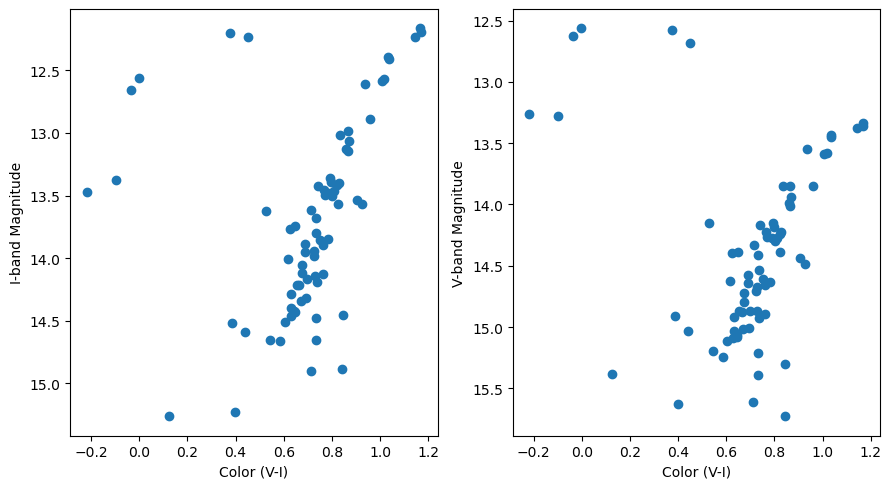

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(9,5))

axs[0].scatter(color, mag_I)
axs[0].invert_yaxis()
axs[0].set_xlabel('Color (V-I)')
axs[0].set_ylabel('I-band Magnitude')

axs[1].scatter(color, mag_V)
axs[1].invert_yaxis()
axs[1].set_xlabel('Color (V-I)')
axs[1].set_ylabel('V-band Magnitude')

plt.tight_layout()
plt.savefig('/mnt/c/Users/panda/Documents/HomeworkBack/ObsTech/LabFive/plots/colormag.pdf')